In [1]:
%matplotlib inline
import waves
import matplotlib.pyplot as plt
import numpy as np

A/D conversion
=============

In [2]:
CD = waves.CDFormatSampler('CD')

SACD = waves.DSDSampler('SACD', 64 * 44100, 16)

# DVD possible combinations (16-, 20- or 24-bits per sample)
# Channels                          | 44.1 kHz | 48 kHz | 88.2 kHz | 96 kHz | 176.4 kHz | 192 kHz
# Mono (1.0)                        |    Yes   |  Yes   |    Yes   |  Yes   |    Yes    |   Yes   
# Stereo (2.0)                      |    Yes   |  Yes   |    Yes   |  Yes   |    Yes    |   Yes   
# Stereo (2.1)                      |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# S+M surround (3.0 or 3.1)         |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# Quad (4.0 or 4.1)                 |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# 3-stereo (3.0 or 3.1)             |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# 3-stereo+M surround (4.0 or 4.1)  |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# Full surround (5.0 or 5.1)        |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
DVDA = waves.PCMSampler('DVD Audio', 88200, 20)

# High Fidelity Blu-ray Pure Audio uses 24 bits at 192 kHz (or also 96 kHz)
BDA = waves.HFPALinearPCM('Blu-Ray Audio')

# Generic, define sampling frequency (Hz) and resolution (bits) to your heart's content
GenericPCM_1 = waves.PCMSampler('PCM 1', 44100, 4) # Same CD frequency, lower resolution
GenericPCM_2 = waves.PCMSampler('PCM 2', 14000, 16) # Same CD resolution, lower frequency

CD's stream (65536 levels): [32767 36645 40444 44087 ... 20397 23979 27739 31601]
PCM 1's stream (16 levels): [8 8 9 10 ... 5 5 6 7]
PCM 2's stream (65536 levels): [32767 44615 54116 59389 ... 6146 6146 11419 20920]


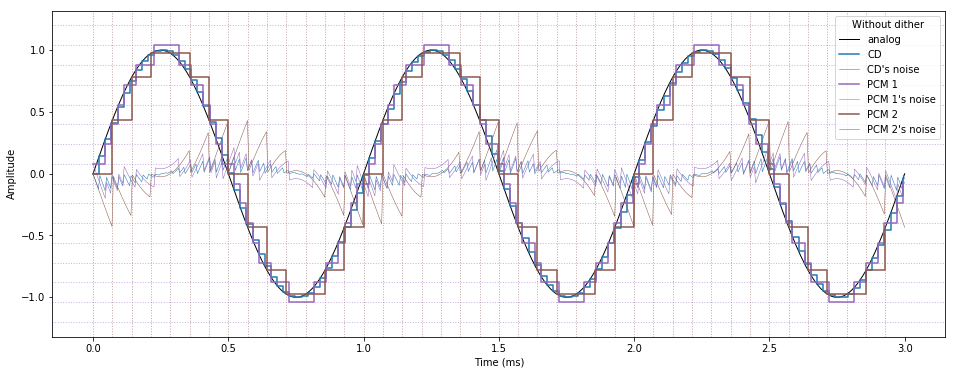

In [3]:
f = 1e3 # 1KHz
audio = waves.AnalogSineWave('analog', f, gain=1, phase=0, infinity=600)
n_waves = 3
length = n_waves * 1/f * 1000 # in miliseconds

noise_nodither = {}
noise_nodither['time_domain'] = audio.plot(length, plt, color='k', lw=1)
_, _, _, noise_nodither[CD.label] = CD.sample(audio, length, plt, lw=1.5)
##SACD.sample(audio, length, plt, color='b', lw=1.5)
#DVDA.sample(audio, length, plt, color='g', lw=1.5)
#BDA.sample(audio, length, plt, color='m', lw=1.5)
_, _, _, noise_nodither[GenericPCM_1.label] = GenericPCM_1.sample(audio, length, plt, lw=1.5)
_, _, _, noise_nodither[GenericPCM_2.label] = GenericPCM_2.sample(audio, length, plt, lw=1.5)
[plt.axvline(t, color=GenericPCM_2.color, lw=1, ls=':', alpha=0.5) for t in np.arange(0, length, GenericPCM_2.sampling_interval)]
[plt.axhline(A, color=GenericPCM_1.color, lw=1, ls=':', alpha=0.5) for A in np.linspace(GenericPCM_1.amp_min, GenericPCM_2.amp_max, GenericPCM_1.levels)]
plt.legend(title='Without dither');
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
plt.gcf().set_size_inches(16, 6)

Let us now add some dither and see how the noise behaves

CD's stream (65536 levels): [32767 36644 40443 44086 ... 20397 23980 27739 31601]
PCM 1's stream (16 levels): [7 8 10 11 ... 5 6 7 7]
PCM 2's stream (65536 levels): [32768 44615 54117 59389 ... 6145 6147 11419 20920]


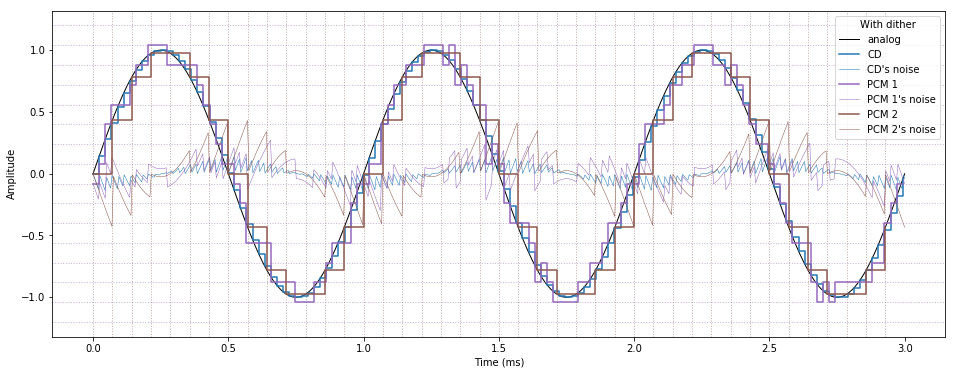

In [4]:
noise_dither = {}
noise_dither['time_domain'] = audio.plot(length, plt, color='k', lw=1)
_, _, _, noise_dither[CD.label] = CD.sample(audio, length, plt, dither=True, lw=1.5)
##SACD.sample(audio, length, plt, color='b', lw=1.5)
#DVDA.sample(audio, length, plt, color='g', lw=1.5)
#BDA.sample(audio, length, plt, color='m', lw=1.5)
_, _, _, noise_dither[GenericPCM_1.label] = GenericPCM_1.sample(audio, length, plt, dither=True, lw=1.5)
_, _, _, noise_dither[GenericPCM_2.label] = GenericPCM_2.sample(audio, length, plt, dither=True, lw=1.5)
[plt.axvline(t, color=GenericPCM_2.color, lw=1, ls=':', alpha=0.5) for t in np.arange(0, length, GenericPCM_2.sampling_interval)]
[plt.axhline(A, color=GenericPCM_1.color, lw=1, ls=':', alpha=0.5) for A in np.linspace(GenericPCM_1.amp_min, GenericPCM_2.amp_max, GenericPCM_1.levels)]
plt.legend(title='With dither')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.gcf().set_size_inches(16, 6)

The noise is now more decorrelated from the signal, at the cost of increased noise power.
See, first the signal-noise correlation:

In [8]:
def show_noise_signal_correlation(signal, noise, ADC_list, leg_title=None):
    fig, ax = plt.subplots(1, 2)
    signal = signal.function(noise['time_domain'])
    for ADC in [CD, GenericPCM_1, GenericPCM_2]:
        ax[0].scatter(signal, noise[ADC.label], color=ADC.color, label=ADC.label)
        ax[1].plot(*waves.twopar_correlation(noise_nodither[ADC.label], signal), color=ADC.color, label=ADC.label)
    ax[0].legend()
    ax[0].set_xlabel('Signal amplitude')
    ax[0].set_ylabel('Noise amplitude')
    ax[1].grid(alpha=0.5)
    ax[1].set_xlabel('Lag')
    ax[1].set_ylabel('Correlation')
    ax[1].legend()
    fig.suptitle(leg_title)
    fig.set_size_inches(16, 6)

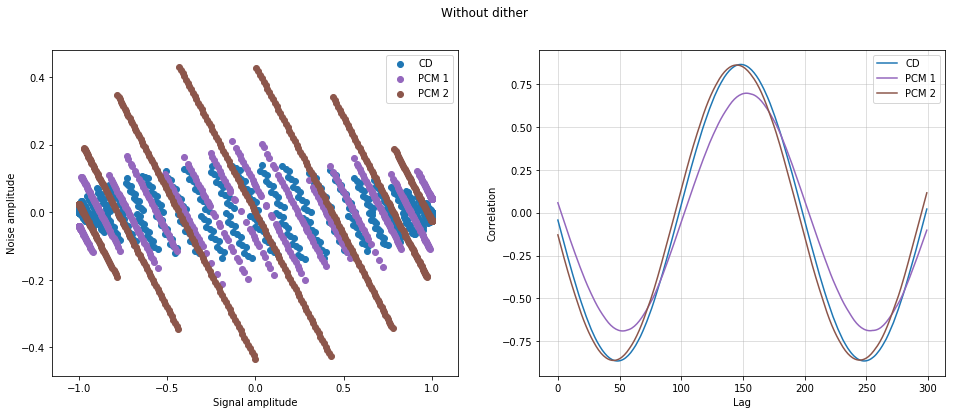

In [9]:
show_noise_signal_correlation(audio, noise_nodither, [CD, GenericPCM_1, GenericPCM_2], leg_title='Without dither')

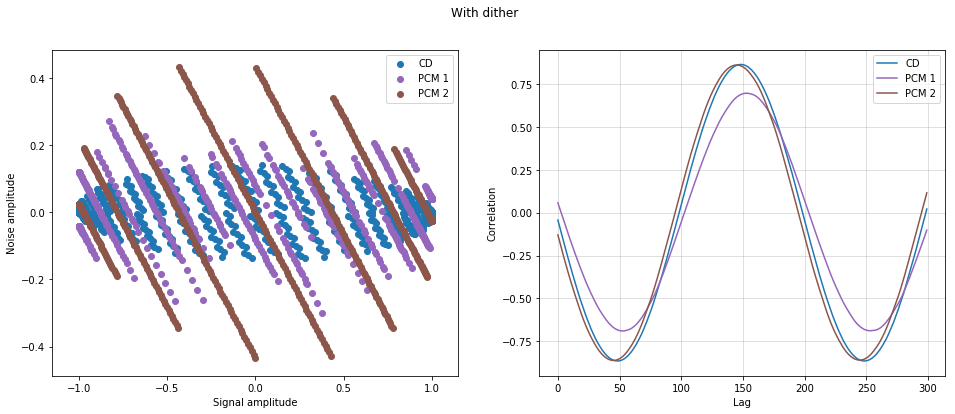

In [10]:
show_noise_signal_correlation(audio, noise_dither, [CD, GenericPCM_1, GenericPCM_2], leg_title='With dither')